# Отток клиентов

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

### Цель:
- Cпрогнозировать, уйдёт клиент из банка в ближайшее время или нет.
- Построить модель с предельно большим значением F1-меры

# Ознакомление и подготовка данных

In [ ]:
# Загрузили библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
from sklearn.utils import shuffle
import warnings
warnings.filterwarnings('ignore')

### Знакомство с данными

In [ ]:
df = pd.read_csv('/datasets/Churn.csv')
display(df.info())
df.columns = df.columns.str.lower() # привели к нижнему регистру
df.head() # проверили и еще раз ознакомились

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


None

,rownumber,customerid,surname,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [ ]:
# Выделим признаки для последующего использования
feature_names = df.columns.to_list() 
print (feature_names)

['rownumber', 'customerid', 'surname', 'creditscore', 'geography', 'gender', 'age', 'tenure', 'balance', 'numofproducts', 'hascrcard', 'isactivemember', 'estimatedsalary', 'exited']


In [ ]:
# Посмотрим на уникальные значения
df.nunique()

rownumber          10000
customerid         10000
surname             2932
creditscore          460
geography              3
gender                 2
age                   70
tenure                11
balance             6382
numofproducts          4
hascrcard              2
isactivemember         2
estimatedsalary     9999
exited                 2
dtype: int64

In [ ]:
# Округлим несколько столбцов
df['tenure'] = df['tenure'].astype('Int64')
df['balance'] = df['balance'].round(0).astype('Int64')
df['estimatedsalary'] = df['estimatedsalary'].round(0).astype('Int64')

In [ ]:
# Найдены Nan - скорее клиент не заполнял данные, либо недвижимости у него нет.
df[df['tenure'].isna()].head()

,rownumber,customerid,surname,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
30,31,15589475,Azikiwe,591,Spain,Female,39,NaN,0,3,1,0,140469,1
48,49,15766205,Yin,550,Germany,Male,38,NaN,103391,1,0,1,90878,0
51,52,15768193,Trevisani,585,Germany,Male,36,NaN,146051,2,0,0,86425,0
53,54,15702298,Parkhill,655,Germany,Male,41,NaN,125562,1,0,0,164041,1
60,61,15651280,Hunter,742,Germany,Male,35,NaN,136857,1,0,0,84510,0


In [ ]:
# Обратимся к статистике
df.describe()

,rownumber,customerid,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,4.997690,76485.893100,1.530200,0.70550,0.515100,100090.236400,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.894723,62397.409041,0.581654,0.45584,0.499797,57510.492127,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,12.000000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.000000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.500000,1.000000,1.00000,1.000000,100193.500000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.000000,2.000000,1.00000,1.000000,149388.000000,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.000000,4.000000,1.00000,1.000000,199992.000000,1.000000


**Вывод:**

1. `rownumber`, `customerid` - признаки идентификаторы, их нужно обработать, либо удалить, т.к. курпные цифры могут привести к дисбалансу;
2. `creditscore` - признак имеет нормальное распределение, min - 350, мах - 850, mean примерно равно median, выбросов нет.
3. `age` - от 18 до 92, нормальное распределение, mean примерно равно median, выброс - 92 года;
4. `balance` - 25% не имеют баланса на карте, большое отклонение, разброс велик;
5. `estimatedsalary` - нормальное распределение, mean примерно равно median.
6. `exited` - из выборки видим, что ушло 20% клиентов. Нужна модель с результативностью более 80%.

### Подготовка данных

In [ ]:
# Обработаем NaN, пропусков не много 
imputer = SimpleImputer(strategy='median') 
df[['rownumber', 'customerid', 'creditscore', 'age', 'tenure', 'balance', 'numofproducts', 'hascrcard', 'isactivemember', 'estimatedsalary', 'exited']] = imputer.fit_transform(df[['rownumber', 'customerid', 'creditscore', 'age', 'tenure', 'balance', 'numofproducts', 'hascrcard', 'isactivemember', 'estimatedsalary', 'exited']])
display(df[df['tenure'].isna()].head()) # проверка пропусков
# 'rownumber','customerid','surname'- нужно удалить, т.к. они не несут смысла для модели
df = df.drop(['rownumber', 'customerid', 'surname'], axis=1)
numeric_features = ['creditscore', 'age', 'tenure', 'balance', 'numofproducts', 'estimatedsalary']
categorical_features = ['geography', 'gender']

,rownumber,customerid,surname,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited


### Проведем категоризацию, масштабирование, разделим выборки: тренировочная, валиадцияонная и тестовая

In [ ]:
# Препроцессинг
# OHE
df = pd.get_dummies(df, drop_first=True)
X = df.drop(['exited'], axis = 1)
y = df['exited']
X_tr, X_test, y_tr, y_test = train_test_split(X, y, test_size=0.2, stratify = y, random_state=42)
# display(X_tr.shape, X_test.shape, y_tr.shape, y_test.shape)
# Проведем масштабирование признаков
scaler = StandardScaler()
scaler.fit(X_tr[numeric_features])
X_tr[numeric_features] = scaler.transform(X_tr[numeric_features])
X_test[numeric_features] = scaler.transform(X_test[numeric_features])
# display(X_tr.head()) # проверим
# Выделим из X_tr, y_tr валидационную выборку
X_tr, X_val, y_tr, y_val = train_test_split(X_tr, y_tr, test_size=0.2, stratify = y_tr, random_state=42)
display(X_tr.head()) # проверим
#display(X_tr.shape, X_val.shape, y_tr.shape, y_val.shape)

,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,geography_Germany,geography_Spain,gender_Male
3006,0.996450,0.575076,-1.446064,0.619244,-0.910256,1.0,0.0,1.563384,0,0,0
5735,-0.680735,0.480075,-0.360532,-1.226059,0.808830,0.0,1.0,0.034836,0,1,0
5652,0.416682,-0.944938,1.448687,-1.226059,0.808830,0.0,0.0,1.742587,0,0,0
26,1.089627,-0.279932,-1.084220,0.970089,-0.910256,1.0,1.0,1.226397,1,0,1
3596,-0.080262,-0.279932,-1.807908,1.152181,-0.910256,0.0,0.0,-0.765631,0,0,1


#### Выводы
1. Проведен препроцессиг: заполнены NaN, удалены признаки не несущие смысл;
2. Разделены выборки, категориальные признаки обработаны методом OHE.

# Исследование задачи

In [ ]:
# Создадим константную модель
target_pred_constant = pd.Series(0, index=y_val.index)
print('Результат константной модели:', accuracy_score(y_val, target_pred_constant))

Результат константной модели: 0.79625


1. Перед нами несбалансированная выборка, распеределение 0 и 1 - 80:20 - как закон Парето;
2. Варианты решения проблемы:
    - Поискать еще данные, запросить у банка больше случаев с уходом клиентов;
    - Синтетически увеличить редкий класс;
    - Синтетически уменьшить частый класс;
    - Использовать другие метрики вместо accuracy для детальной фиксации;
    - Использовать гиперпараметр class_weigth = 'balanced';
    - Использовать матрицу ошибок для визуального контроля.

- Начнем проверку моделей без и с балансом классов

In [ ]:
# Создадим функцю для логистической регрессии
def lr(features_tr, target_tr, features_val, target_val, class_weight):
    lr = LogisticRegression(class_weight=class_weight, random_state=42, solver='liblinear')
    lr.fit(features_tr, target_tr)
    predictions = lr.predict(features_val)
    precision = precision_score(target_val, predictions)
    recall = recall_score(target_val, predictions)
    f1 = f1_score(target_val, predictions)
    
    probabilities_valid = lr.predict_proba(features_val)
    probabilities_one_valid = probabilities_valid[:, 1]
    roc = roc_auc_score(target_val, probabilities_one_valid)
    result = accuracy_score(target_val, predictions)
    print("F1 = {:.2f} | Точность = {:.3f}, Полнота = {:.3f} | ROC-AUC = {:.2f} | Accuracy = {:.2f}".format(
        f1, precision, recall, roc, result))
    print(confusion_matrix(target_val, predictions))

In [ ]:
# без баланса классов
lr(X_tr, y_tr, X_val, y_val, None)

F1 = 0.32 | Точность = 0.619, Полнота = 0.215 | ROC-AUC = 0.76 | Accuracy = 0.81
[[1231   43]
 [ 256   70]]


- accuracy примерно равна константной модели;
- очень много ошибок FN.

In [ ]:
# с балансом
lr(X_tr, y_tr, X_val, y_val, 'balanced')

F1 = 0.48 | Точность = 0.373, Полнота = 0.669 | ROC-AUC = 0.76 | Accuracy = 0.70
[[907 367]
 [108 218]]


- accuracy резко снизилась, но зато возросла метрика F1;
- модель из выборки 1600 строк 585 раз посоветовала 1, TP - 218, а вот FP - 367;
- очень маниакально-депрессивная модель, полный конец света! По ее мнению 1/3 клиентов должна уйти. Такой модели нам не нужно.

In [ ]:
Random_tree = DecisionTreeClassifier()
grid = {'max_depth': range (1, 10)}
tree_rs = RandomizedSearchCV(Random_tree, n_jobs=None, n_iter=10,
                                 param_distributions=grid, random_state=42, scoring='f1')
tree_rs.fit(X_tr, y_tr)
print('Best Params: \n', tree_rs.best_params_ )

Best Params: 
 {'max_depth': 6}


In [ ]:
# Создадим функцию - модель Tree
def tree(features_tr, target_tr, features_val, target_val, cl_w, depth):
    tree = DecisionTreeClassifier(class_weight=cl_w, random_state=42, max_depth = depth)
    tree.fit(features_tr, target_tr)
    predictions = tree.predict(features_val)
    precision = precision_score(target_val, predictions)
    recall = recall_score(target_val, predictions)
    f1 = f1_score(target_val, predictions)
    
    probabilities_valid = tree.predict_proba(features_val)
    probabilities_one_valid = probabilities_valid[:, 1]
    roc = roc_auc_score(target_val, probabilities_one_valid)
    result = accuracy_score(target_val, predictions)
    print("F1 = {:.2f} | Точность = {:.3f}, Полнота = {:.3f} | ROC-AUC = {:.2f} | Accuracy = {:.2f}".format(
        f1, precision, recall, roc, result))
    print(confusion_matrix(target_val, predictions))

In [ ]:
tree(X_tr, y_tr, X_val, y_val, None, 6)

F1 = 0.57 | Точность = 0.781, Полнота = 0.448 | ROC-AUC = 0.83 | Accuracy = 0.86
[[1233   41]
 [ 180  146]]


- Уже лучше константной модели;
- FP - не много, но TP - мало, зато Точность на высоте.
- F1 - 0.57

In [ ]:
Random_tree = DecisionTreeClassifier(class_weight='balanced')
grid = {'max_depth': range (1, 10)}
tree_rs = RandomizedSearchCV(Random_tree, n_jobs=None, n_iter=10,
                                 param_distributions=grid, random_state=42, scoring='f1')
tree_rs.fit(X_tr, y_tr)
print('Best Params: \n', tree_rs.best_params_ )

Best Params: 
 {'max_depth': 5}


In [ ]:
# проверили модель Tree -'balanced'
tree(X_tr, y_tr, X_val, y_val, 'balanced', 5)

F1 = 0.58 | Точность = 0.482, Полнота = 0.742 | ROC-AUC = 0.83 | Accuracy = 0.79
[[1014  260]
 [  84  242]]


- как и с ЛогРегр, при балансировке с помощью гиперпараметра accuracy упала до константной модели, очень много FP ошибок;
- Полнота выросла до 0,72;
- f1 понизилась из-за падения точности.

In [ ]:
# Подберем гиперпараметры для случайного леса
Random_forest = RandomForestClassifier(min_samples_leaf=4)
grid = { 'n_estimators': range (20, 90, 10),
        'max_depth': range (1, 11, 1) }
forest_rs = RandomizedSearchCV(Random_forest, n_jobs=4, n_iter=20,
                                 param_distributions=grid, random_state=42, scoring='f1')
forest_rs.fit(X_tr, y_tr)
print('Best Params: \n', forest_rs.best_params_ )

Best Params: 
 {'n_estimators': 60, 'max_depth': 10}


In [ ]:
# Создадим функцию - модель Случайного леса
def forest(features_tr, target_tr, features_val, target_val, cl_w, depth, est, msl):
    forest = RandomForestClassifier(bootstrap=True, class_weight=cl_w, criterion='gini',
                       max_depth=depth, min_samples_leaf=msl, n_estimators=est, random_state=42)
    forest.fit(features_tr, target_tr,)
    predictions = forest.predict(features_val)
    precision = precision_score(target_val, predictions)
    recall = recall_score(target_val, predictions)
    f1 = f1_score(target_val, predictions)
    
    probabilities_valid = forest.predict_proba(features_val)
    probabilities_one_valid = probabilities_valid[:, 1]
    roc = roc_auc_score(target_val, probabilities_one_valid)
    result = accuracy_score(target_val, predictions)
    print("F1 = {:.2f} | Точность = {:.3f}, Полнота = {:.3f} | ROC-AUC = {:.2f} | Accuracy = {:.2f}".format(
        f1, precision, recall, roc, result))
    print(confusion_matrix(target_val, predictions))    

In [ ]:
# Подставим параметры в функцию, без баланса
forest(X_tr, y_tr, X_val, y_val, None, 10, 60, 4)

F1 = 0.55 | Точность = 0.815, Полнота = 0.420 | ROC-AUC = 0.86 | Accuracy = 0.86
[[1243   31]
 [ 189  137]]


- accuracy выше конст.модели на 6%;
- F1 - небольшая из-за низкой метрики Полнота;
- Зато высокая точность - 0,815;

In [ ]:
# Подберем гиперпараметры для случайного леса - 'balanced'
Random_forest = RandomForestClassifier(class_weight='balanced')
grid = { 'n_estimators': range (20, 90, 10),
        'max_depth': range (1, 11, 1),
       'min_samples_leaf': range (2,5,1) }
forest_rs = RandomizedSearchCV(Random_forest, n_jobs=4, n_iter=30,
                                 param_distributions=grid, random_state=42, scoring='f1')
forest_rs.fit(X_tr, y_tr)
print('Best Params: \n', forest_rs.best_params_ )

Best Params: 
 {'n_estimators': 70, 'min_samples_leaf': 4, 'max_depth': 9}


In [ ]:
# Проверим модель Случайного леса - 'balanced'
forest(X_tr, y_tr, X_val, y_val, 'balanced', 9, 70, 4)

F1 = 0.63 | Точность = 0.593, Полнота = 0.666 | ROC-AUC = 0.86 | Accuracy = 0.84
[[1125  149]
 [ 109  217]]


- accuracy уменьшилось на 2%, т.к. резко возросли FP ошибки;
- f1 одна из лучших;

In [ ]:
# Подберем гиперпараметры для GBClass
Random_gbc = GradientBoostingClassifier(min_samples_leaf=3)
grid = { 'learning_rate': np.arange (0.1, 0.3, 0.1),
        'n_estimators': range (100, 150, 10), 
        'max_depth': range (1,11, 1) }
gbc_rs = RandomizedSearchCV(Random_gbc, n_jobs=2, n_iter=20,
                                 param_distributions=grid, random_state=42, scoring='f1')
gbc_rs.fit(X_tr, y_tr)
print('Best Params: \n', gbc_rs.best_params_ )

Best Params: 
 {'n_estimators': 120, 'max_depth': 3, 'learning_rate': 0.1}


In [ ]:
# Создадим функцию - модель градиентный бустинг
def gradboost(features_tr, target_tr, features_val, target_val, l_r, depth, est, msl):
    gradboost = GradientBoostingClassifier(learning_rate=l_r, max_depth=depth, 
                            min_samples_leaf=msl, n_estimators=est, random_state=42)
    gradboost.fit(features_tr, target_tr,)
    predictions = gradboost.predict(features_val)
    precision = precision_score(target_val, predictions)
    recall = recall_score(target_val, predictions)
    f1 = f1_score(target_val, predictions)
    
    probabilities_valid = gradboost.predict_proba(features_val)
    probabilities_one_valid = probabilities_valid[:, 1]
    roc = roc_auc_score(target_val, probabilities_one_valid)
    result = accuracy_score(target_val, predictions)
    print("F1 = {:.2f} | Точность = {:.3f}, Полнота = {:.3f} | ROC-AUC = {:.2f} | Accuracy = {:.2f}".format(
        f1, precision, recall, roc, result))
    print(confusion_matrix(target_val, predictions)) 

In [ ]:
gradboost(X_tr, y_tr, X_val, y_val, 0.1, 3, 120, 3)

F1 = 0.57 | Точность = 0.774, Полнота = 0.451 | ROC-AUC = 0.85 | Accuracy = 0.86
[[1231   43]
 [ 179  147]]


- Значения метрик немного хуже, чем у случайного леса;
- 'balanced' - гиперпараметра нет.

# 3. Борьба с дисбалансом<a id="research2"></a>

**Upsampling**<a id="upsample"></a>

In [ ]:
# Upsampling - синтетичкски увеличим редкий класс.
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

**Проведем проверку на всех моделях**

In [ ]:
# ЛР
features_upsampled, target_upsampled = upsample(X_tr, y_tr, 4)
lr(features_upsampled, target_upsampled, X_val, y_val, None)

F1 = 0.48 | Точность = 0.371, Полнота = 0.681 | ROC-AUC = 0.76 | Accuracy = 0.70
[[897 377]
 [104 222]]


- Опять маниакально-депрессивная модель, все уйдут!

In [ ]:
# проверим модель Tree
features_upsampled_1, target_upsampled_1 = upsample(X_tr, y_tr, 4)

In [ ]:
Random_tree = DecisionTreeClassifier()
grid = {'max_depth': range (1, 10)}
tree_rs = RandomizedSearchCV(Random_tree, n_jobs=None, n_iter=10,
                                 param_distributions=grid, random_state=42)
tree_rs.fit(features_upsampled_1, target_upsampled_1)
print('Best Params: \n', tree_rs.best_params_ )

Best Params: 
 {'max_depth': 9}


In [ ]:
tree(features_upsampled_1, target_upsampled_1, X_val, y_val, None, 9)

F1 = 0.56 | Точность = 0.459, Полнота = 0.724 | ROC-AUC = 0.79 | Accuracy = 0.77
[[996 278]
 [ 90 236]]


- Увеличение выборки привело к увеличению качества, если применить еще балансировку, то будет как ЛогРегр.

In [ ]:
# Проверим модель Случайного леса
features_upsampled_2, target_upsampled_2 = upsample(X_tr, y_tr, 4)

In [ ]:
# Подберем гиперпараметры для случайного леса
Random_forest = RandomForestClassifier()
grid = { 'n_estimators': range (20, 90, 10),
        'max_depth': range (1, 11, 1),
       'min_samples_leaf': range(2, 5, 1) }
forest_rs = RandomizedSearchCV(Random_forest, n_jobs=4, n_iter=50,
                                 param_distributions=grid, random_state=42)
forest_rs.fit(features_upsampled_2, target_upsampled_2)
print('Best Params: \n', forest_rs.best_params_ )

Best Params: 
 {'n_estimators': 50, 'min_samples_leaf': 2, 'max_depth': 10}


In [ ]:
forest(features_upsampled_2, target_upsampled_2, X_val, y_val, None, 10, 50, 2)

F1 = 0.62 | Точность = 0.559, Полнота = 0.699 | ROC-AUC = 0.86 | Accuracy = 0.83
[[1094  180]
 [  98  228]]


<font color='purple'>
    
- При Repeat = 4 - f1 - 0,62;
    
- При Repeat = 3 - f1 - 0,64;
    
- При Repeat = 3 на тесте f1 падает до 0,61</font>

In [ ]:
# Проверим градиентный бустинг
features_upsampled_4, target_upsampled_4 = upsample(X_tr, y_tr, 4)

In [ ]:
# Подберем гиперпараметры для GBClass
Random_gbc = GradientBoostingClassifier(min_samples_leaf=4)
grid = { 'learning_rate': np.arange (0.1, 0.3, 0.1),
        'n_estimators': range (100, 150, 10), 
        'max_depth': range (1,11, 1) }
gbc_rs = RandomizedSearchCV(Random_gbc, n_jobs=4, n_iter=20,
                                 param_distributions=grid, random_state=42, scoring='f1')
gbc_rs.fit(features_upsampled_4, target_upsampled_4)
print('Best Params: \n', gbc_rs.best_params_ )

Best Params: 
 {'n_estimators': 100, 'max_depth': 9, 'learning_rate': 0.2}


In [ ]:
gradboost(features_upsampled_4, target_upsampled_4, X_val, y_val, 0.2, 9, 100, 4)

F1 = 0.60 | Точность = 0.678, Полнота = 0.543 | ROC-AUC = 0.85 | Accuracy = 0.85
[[1190   84]
 [ 149  177]]


- Модели Случайного леса и градиентного бустинг увеличили качество с помощью увеличения редкого класса.

**Downsampling**<a id="downsample"></a>

In [ ]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

- Проверка всех моделей при понижении выборки с классом - 0.

In [ ]:
# проверим модель ЛР
features_downsampled, target_downsampled = downsample(X_tr, y_tr, 0.5)
lr(features_downsampled, target_downsampled, X_val, y_val, None)

F1 = 0.47 | Точность = 0.503, Полнота = 0.448 | ROC-AUC = 0.76 | Accuracy = 0.80
[[1130  144]
 [ 180  146]]


In [ ]:
# проверим модель Tree
features_downsampled_1, target_downsampled_1 = downsample(X_tr, y_tr, 0.5)

In [ ]:
Random_tree = DecisionTreeClassifier()
grid = {'max_depth': range (1, 10)}
tree_rs = RandomizedSearchCV(Random_tree, n_jobs=None, n_iter=10,
                                 param_distributions=grid, random_state=42, scoring='f1')
tree_rs.fit(features_downsampled_1, target_downsampled_1)
print('Best Params: \n', tree_rs.best_params_ )

Best Params: 
 {'max_depth': 6}


In [ ]:
tree(features_downsampled_1, target_downsampled_1, X_val, y_val, None, 6)

F1 = 0.58 | Точность = 0.691, Полнота = 0.494 | ROC-AUC = 0.85 | Accuracy = 0.85
[[1202   72]
 [ 165  161]]


In [ ]:
# Проверим модель Случайного леса
features_downsampled_2, target_downsampled_2 = downsample(X_tr, y_tr, 0.5)

In [ ]:
# Подберем гиперпараметры для случайного леса
Random_forest = RandomForestClassifier()
grid = { 'n_estimators': range (20, 90, 10),
        'max_depth': range (1, 11, 1),
       'min_samples_leaf': range(2, 5, 1) }
forest_rs = RandomizedSearchCV(Random_forest, n_jobs=4, n_iter=50,
                                 param_distributions=grid, random_state=42, scoring='f1')
forest_rs.fit(features_downsampled_2, target_downsampled_2)
print('Best Params: \n', forest_rs.best_params_ )

Best Params: 
 {'n_estimators': 70, 'min_samples_leaf': 4, 'max_depth': 9}


In [ ]:
forest(features_downsampled_2, target_downsampled_2, X_val, y_val, None, 10, 60, 3)

F1 = 0.62 | Точность = 0.673, Полнота = 0.574 | ROC-AUC = 0.86 | Accuracy = 0.86
[[1183   91]
 [ 139  187]]


In [ ]:
# Проверим градиентный бустинг
features_downsampled_4, target_downsampled_4 = downsample(X_tr, y_tr, 0.5)

In [ ]:
# Подберем гиперпараметры для GBClass
Random_gbc = GradientBoostingClassifier(min_samples_leaf=4)
grid = { 'learning_rate': np.arange (0.1, 0.3, 0.1),
        'n_estimators': range (100, 150, 10), 
        'max_depth': range (1,11, 1) }
gbc_rs = RandomizedSearchCV(Random_gbc, n_jobs=4, n_iter=30,
                                 param_distributions=grid, random_state=42, scoring='f1')
gbc_rs.fit(features_downsampled_4, target_downsampled_4)
print('Best Params: \n', gbc_rs.best_params_ )

Best Params: 
 {'n_estimators': 120, 'max_depth': 3, 'learning_rate': 0.1}


In [ ]:
gradboost(features_downsampled_4, target_downsampled_4, X_val, y_val, 0.1, 3, 120, 4)

F1 = 0.61 | Точность = 0.643, Полнота = 0.580 | ROC-AUC = 0.86 | Accuracy = 0.85
[[1169  105]
 [ 137  189]]


**Вывод**
- Искусственно изменяю выборки классов можно как улучшить качество, так и сделать модель невменяемой.

**Изменение порога, PR и ROC-кривые на лучшей моделе**<a id="roc"></a>

In [ ]:
# Проверим модель Случайного леса
forest_best = RandomForestClassifier(bootstrap=True, class_weight='balanced', criterion='gini',
                       max_depth=9, min_samples_leaf=4, n_estimators=70, random_state=42)
forest_best.fit(X_tr, y_tr)
probabilities_valid = forest_best.predict_proba(X_val)
probabilities_one_valid = probabilities_valid[:, 1]
for threshold in np.arange(0.3, 0.8, 0.02):
    predicted_valid = probabilities_one_valid > threshold
    precision = precision_score(y_val, predicted_valid)
    recall = recall_score(y_val, predicted_valid)
    f1 = f1_score(y_val, predicted_valid)
    roc = roc_auc_score(y_val, predicted_valid)
    print("Порог = {:.2f} | Точность = {:.3f}, Полнота = {:.3f} | f1 = {:.2f} | ROC-AUC = {:.2f} ".format(threshold, precision, recall, f1, roc))

Порог = 0.30 | Точность = 0.365, Полнота = 0.883 | f1 = 0.52 | ROC-AUC = 0.75 
Порог = 0.32 | Точность = 0.390, Полнота = 0.868 | f1 = 0.54 | ROC-AUC = 0.76 
Порог = 0.34 | Точность = 0.415, Полнота = 0.856 | f1 = 0.56 | ROC-AUC = 0.77 
Порог = 0.36 | Точность = 0.435, Полнота = 0.834 | f1 = 0.57 | ROC-AUC = 0.78 
Порог = 0.38 | Точность = 0.461, Полнота = 0.822 | f1 = 0.59 | ROC-AUC = 0.79 
Порог = 0.40 | Точность = 0.477, Полнота = 0.791 | f1 = 0.60 | ROC-AUC = 0.78 
Порог = 0.42 | Точность = 0.504, Полнота = 0.773 | f1 = 0.61 | ROC-AUC = 0.79 
Порог = 0.44 | Точность = 0.523, Полнота = 0.742 | f1 = 0.61 | ROC-AUC = 0.78 
Порог = 0.46 | Точность = 0.540, Полнота = 0.712 | f1 = 0.61 | ROC-AUC = 0.78 
Порог = 0.48 | Точность = 0.563, Полнота = 0.684 | f1 = 0.62 | ROC-AUC = 0.77 
Порог = 0.50 | Точность = 0.593, Полнота = 0.666 | f1 = 0.63 | ROC-AUC = 0.77 
Порог = 0.52 | Точность = 0.610, Полнота = 0.638 | f1 = 0.62 | ROC-AUC = 0.77 
Порог = 0.54 | Точность = 0.637, Полнота = 0.626 | f

**Вывод**
- Использование данной модели очень разнооборазное, мы имеем интервал порогов с высокими метриками f1 и ROC-AUC, они могут сделать модель строгой к отбору класса - 1, либо наоборот увеличивать предсказания класса 1 жертвую точностью, но не сильно, как это было в логистической регрессии;
- Максимальное значение f1 достигнуто при пороге 0.5-0.54;
- А ROC_AUC - 0.79 говорить нам, что соотношение класса TPR больше FPR при пороге 0.42 и значении Полноты - 0.773. Данное значение достигнуто при f1 - 0.61.

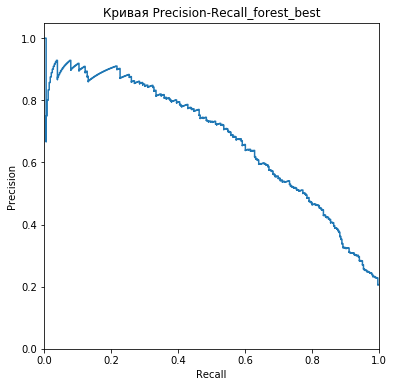

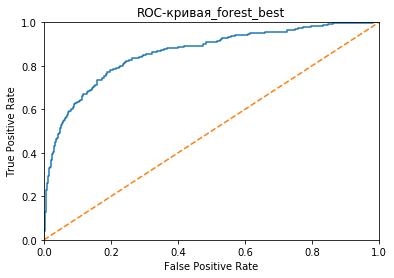

In [ ]:
# Отобразим полученные цифры в виде графика
precision, recall, thresholds = precision_recall_curve(y_val, probabilities_valid[:, 1])
plt.figure(figsize=(6, 6))
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Кривая Precision-Recall_forest_best')
plt.show()
fpr, tpr, thresholds = roc_curve(y_val, probabilities_valid[:, 1])
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая_forest_best')
plt.show()

# 4. Тестирование модели<a id="test"></a>

1. **Тестирование Случайного леса - 'balanced' and downsampling (frac=0.5)** 

In [ ]:
forest(X_tr, y_tr, X_test, y_test, 'balanced', 9, 70, 4)

F1 = 0.63 | Точность = 0.586, Полнота = 0.688 | ROC-AUC = 0.86 | Accuracy = 0.84
[[1395  198]
 [ 127  280]]


In [ ]:
forest(features_downsampled_2, target_downsampled_2, X_test, y_test, None, 10, 60, 3)

F1 = 0.62 | Точность = 0.648, Полнота = 0.587 | ROC-AUC = 0.86 | Accuracy = 0.85
[[1463  130]
 [ 168  239]]


In [ ]:
# Соединим Train and Valid и обучим на этих данных лучшую модель
X_tr_v = pd.concat([X_tr, X_val], axis=0)
X_tr_v

,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,geography_Germany,geography_Spain,gender_Male
3006,0.996450,0.575076,-1.446064,0.619244,-0.910256,1.0,0.0,1.563384,0,0,0
5735,-0.680735,0.480075,-0.360532,-1.226059,0.808830,0.0,1.0,0.034836,0,1,0
5652,0.416682,-0.944938,1.448687,-1.226059,0.808830,0.0,0.0,1.742587,0,0,0
26,1.089627,-0.279932,-1.084220,0.970089,-0.910256,1.0,1.0,1.226397,1,0,1
3596,-0.080262,-0.279932,-1.807908,1.152181,-0.910256,0.0,0.0,-0.765631,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
6760,0.106092,0.195072,0.001312,-1.226059,-0.910256,0.0,1.0,-0.199730,0,0,1
2105,-1.643564,-0.754936,0.724999,-1.226059,0.808830,1.0,1.0,-0.876792,0,0,0
2311,-0.059556,-1.894947,1.448687,0.836843,-0.910256,0.0,0.0,1.329778,0,0,1
4728,-1.550387,0.100072,0.001312,0.614381,-0.910256,0.0,0.0,0.467547,1,0,1


In [ ]:
y_tr_v = pd.concat([y_tr] + [y_val])
y_tr_v

3006    1.0
5735    0.0
5652    0.0
26      0.0
3596    0.0
       ... 
6760    0.0
2105    0.0
2311    0.0
4728    0.0
5566    0.0
Name: exited, Length: 8000, dtype: float64

In [ ]:
forest(X_tr_v, y_tr_v, X_test, y_test, 'balanced', 9, 70, 4)

F1 = 0.62 | Точность = 0.557, Полнота = 0.705 | ROC-AUC = 0.86 | Accuracy = 0.83
[[1365  228]
 [ 120  287]]


In [ ]:
features_downsampled_new, target_downsampled_new = downsample(X_tr_v, y_tr_v, 0.5)
forest(features_downsampled_new, target_downsampled_new, X_test, y_test, None, 10, 60, 3)

F1 = 0.61 | Точность = 0.644, Полнота = 0.582 | ROC-AUC = 0.86 | Accuracy = 0.85
[[1462  131]
 [ 170  237]]


#### Общий вывод<a id="result"></a>
- Созданы и проверены 4 модели из них выявлены лучшие модели, которые более точно определили признаки, влияющие на уход клиентов;
- Результат на тесте упал на 1 деление, но он выше 0.59;
- Модели не помогут удержать клиентов, но помогут руководству банка принять правильное решение;
- С помощью графиков и пороговых значений мы можем регулировать строгость модели, если мы боимся ухода клиентов, либо скорость ухода повышается - мы понижаем порог, увеличивая работу сотрудников банка (обзвон клиентов, разработка новых продуктов для удержания, сокращение комиссий по брокерскому обслуживанию, повышение ставок по вкладам), т.к. потенциальных клиентов с классом 1 стало больше (увеличились TP and FP). Если же ситуация выравнивается, либо нужно сократить ресурсы - мы повышаем порог - увеличивая точность модели и уменьшая и TP, и FP.